In [406]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress


In [407]:
def process_language_files(language, language_folder, md_folder):

    # Initialize variables for language and md data
    language_data = []
    md_data = []

    # Process files in the Language folder
    for file in os.listdir(language_folder):
        if file.endswith('.csv') and language in file:  # Match the language

            file_path = os.path.join(language_folder, file) # Read the path of an individual file
            df = pd.read_csv(file_path)  # Load CSV file
            df = df.fillna(0)   # Fill missing values with 0s

            # Extract only ROI activation columns (starting from 5th column)
            language_data.append(df.iloc[:, 4:].values)

    # Process files in the MD folder (same as Language)
    for file in os.listdir(md_folder):
        if file.endswith('.csv') and language in file:

            file_path = os.path.join(md_folder, file)
            df = pd.read_csv(file_path)
            df = df.fillna(0)

            md_data.append(df.iloc[:, 4:].values)

    # Average across participants for both systems
    language_matrix = np.mean(np.stack(language_data, axis=0), axis=0)  # Average for Language system
    md_matrix = np.mean(np.stack(md_data, axis=0), axis=0)  # Average for MD system

    return language_matrix, md_matrix

In [408]:
# Function for performing the Fisher Transform on the data
def fisher_transform(correlation_matrix):
    # Clip values to avoid division by zero in arctanh
    clipped_matrix = np.clip(correlation_matrix, -0.9999, 0.9999)
    return np.arctanh(clipped_matrix)

In [409]:
# Function for calculating region averages for a matrix
def calculate_region_averages(matrix):

    # Create a mask to exclude the main diagonal
    mask = np.eye(matrix.shape[0], dtype=bool)
    
    # Define the specific regions
    Language_region = matrix[:12, :12]
    MD_region = matrix[12:, 12:]
    
    # Lang_MD is the rest of the matrix (upper-right and lower-left)
    Lang_MD_top_right = matrix[:12, 12:]
    Lang_MD_bottom_left = matrix[12:, :12]
    Lang_MD_region = np.concatenate((Lang_MD_top_right.flatten(), Lang_MD_bottom_left.flatten()))

    # Remove diagonal elements from Language_region and MD_region
    Language_mask = ~mask[:12, :12]
    MD_mask = ~mask[12:, 12:]
    Language_region_no_diag = Language_region[Language_mask]
    MD_region_no_diag = MD_region[MD_mask]

    # Debugging: Print values and shapes for verification
    print("Language_region shape:", Language_region_no_diag.shape)
    print("Language_region values:\n", Language_region_no_diag)
    print("MD_region shape:", MD_region_no_diag.shape)
    print("MD_region values:\n", MD_region_no_diag)
    print("Lang_MD_region size:", Lang_MD_region.size)
    print("Lang_MD_region values:\n", Lang_MD_region)

    # Calculate averages ignoring the diagonal
    Language_avg = np.mean(Language_region_no_diag)
    MD_avg = np.mean(MD_region_no_diag)
    Lang_MD_avg = np.mean(Lang_MD_region)

    # Debugging: Print calculated averages
    print("Language_avg:", Language_avg)
    print("MD_avg:", MD_avg)
    print("Lang_MD_avg:", Lang_MD_avg)

    return Language_avg, MD_avg, Lang_MD_avg

In [410]:
# Define data to work on

paradigm = "story"    # option to choose the paradigm. "story" for Story Comprehension and "resting" for Resting State

# Story Comprehension
if (paradigm == "story"):
    language_data_path = r"C:\Users\samue\Desktop\Python_BarIlan\Python_Final_Project\Data\Alice_TimeSeriesData_Language_StoryComprehension"
    md_data_path = r"C:\Users\samue\Desktop\Python_BarIlan\Python_Final_Project\Data\Alice_TimeSeriesData_MD_StoryComprehension"

#Resting State
elif (paradigm == "resting"):
    language_data_path = r"C:\Users\samue\Desktop\Python_BarIlan\Python_Final_Project\Data\Alice_TimeSeriesData_Language_RestingState"
    md_data_path = r"C:\Users\samue\Desktop\Python_BarIlan\Python_Final_Project\Data\Alice_TimeSeriesData_MD_RestingState"

assert paradigm == "resting" or paradigm == "story", "Unexpected paradigm selected. Please choose 'story' for story comprehension or 'resting' for Resting State"
assert os.path.exists(language_data_path) == True, "Path to the Language Data folder does not exist. Please specify correct path."
assert os.path.exists(md_data_path) == True, "Path to the MD Data folder does not exist. Please specify correct path."

#Output path for saving results
output_folder = r"C:\Users\samue\Desktop\Python_BarIlan\Python_Final_Project\Matrices\Resting_NoFish"

fisher = True # option to choose if the Fisher transform will be applied to the data. If True, then transform is applied
assert type(fisher) == bool, "'Fisher parameter is not a boolean. Please assign a logical value (1 if You want Fisher transform to be applied)'"

In [411]:
# Ensure the output folder exists, create it if not
os.makedirs(output_folder, exist_ok=True)

In [412]:
# Create a list of languages to be processed
language_list = [
    "Armenian", "Irish", "Greek", "Catalan", "French", "Italian", "Portuguese", "Romanian", "Spanish", "Afrikaans",
    "Danish", "Dutch", "English", "German", "Norwegian", "Swedish", "Belarusian", "Bulgarian", "Czech", "Latvian",
    "Lithuanian", "Polish", "Russian", "Serbocroatian", "Slovene", "Ukrainian", "Farsi", "Gujarati", "Hindi",
    "Marathi", "Nepali", "Arabic", "Hebrew", "Vietnamese", "Tagalog", "Tamil", "Telugu", "Japanese", "Korean", "Swahili",
    "Mandarin", "Finnish", "Hungarian", "Turkish", "Basque"
]

In [413]:
# Prepare a dictionary to store region averages
region_averages = {}

# Dictionary to store matrix values for each language
all_matrices = {}

In [414]:
# Loop through each language
for target_language in language_list:

    print(f"Processing language: {target_language}")

    try:
        # Process the data files for the current language
        language_data, md_data = process_language_files(
            language=target_language,
            language_folder=language_data_path,
            md_folder=md_data_path
        )

        # Debugging, checking shape of the resultant data
        print(f"Language data shape: {language_data.shape}")
        print(f"MD data shape: {md_data.shape}")

        # Combine Language and MD matrices
        combined_matrix = np.vstack([language_data, md_data])

        # Debugging, shape of the combined matrix
        print(f"MD data shape: {md_data.shape}")

        # Compute the full 30x30 correlation matrix
        full_corr_matrix = np.corrcoef(combined_matrix)

        # Debugging, shape of the full correlation matrix
        print(f"Full correlation matrix shape: {full_corr_matrix.shape}")

        # Calculate region averages and store them
        if (fisher == True):

            # Apply Fisher transformation
            fisher_corr_matrix = fisher_transform(full_corr_matrix)

            # Store the currently processed correlation matrix
            all_matrices[target_language] = fisher_corr_matrix

            # Debugging. Verify type and shape of the currently processed matrix after saving
            print(f"Assigning matrix for {target_language}.")
            print(f"Matrix type: {type(all_matrices[target_language])}, shape: {all_matrices[target_language].shape}")

            # Calculate region averages 
            averages = calculate_region_averages(fisher_corr_matrix)

        else:

            all_matrices[target_language] = full_corr_matrix

            print(f"Assigning matrix for {target_language}.")
            print(f"Matrix type: {type(all_matrices[target_language])}, shape: {all_matrices[target_language].shape}")

            averages = calculate_region_averages(full_corr_matrix)

        # Save the region averages for currently processed language
        region_averages[target_language] = {
            "Language_avg": averages[0],
            "MD_avg": averages[1],
            "Lang_MD_avg": averages[2],
        }

        # Visualize the combined matrix
        plt.figure(figsize=(12, 12))
        if (fisher == True):
            plt.imshow(
                fisher_corr_matrix,
                cmap=plt.get_cmap('Spectral').reversed(),
                aspect='equal'
            )
        else:
           plt.imshow(
                full_corr_matrix,
                cmap=plt.get_cmap('Spectral').reversed(),
                aspect='equal'
            )

        plt.title(y=1.1, label=target_language, size='xx-large')

        # Set lines separating regions and hemispheres for better visibility
        plt.axhline(y=5.5, color='black', linewidth=1.5)
        plt.axhline(y=11.5, color='black', linewidth=2.0)
        plt.axhline(y=20.5, color='black', linewidth=1.5)

        plt.axvline(x=5.5, color='black', linewidth=1.5)
        plt.axvline(x=11.5, color='black', linewidth=2.0)
        plt.axvline(x=20.5, color='black', linewidth=1.5)

        # Add section labels for Language and MD (LH and RH)
        plt.text(-0.5, 3, "Language LH", va='center', ha='right', fontsize=12, rotation=90, color='black')
        plt.text(-0.5, 8.5, "Language RH", va='center', ha='right', fontsize=12, rotation=90, color='black')
        plt.text(-0.5, 14.5, "MD LH", va='center', ha='right', fontsize=12, rotation=90, color='black')
        plt.text(-0.5, 25, "MD RH", va='center', ha='right', fontsize=12, rotation=90, color='black')

        plt.text(3, -1.0, "Language LH", va='center', ha='center', fontsize=12, color='black')
        plt.text(8.5, -1.0, "Language RH", va='center', ha='center', fontsize=12, color='black')
        plt.text(14.5, -1.0, "MD LH", va='center', ha='center', fontsize=12, color='black')
        plt.text(25, -1.0, "MD RH", va='center', ha='center', fontsize=12, color='black')

        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

        # Save the figure
        output_path = os.path.join(output_folder, f"{target_language}.png")
        #plt.savefig(output_path)
        plt.close()

        print(f"Saved correlation matrix for {target_language} to {output_path}")



    except Exception as e:
        print(f"An error occurred while processing {target_language}: {e}")

Processing language: Armenian
Language data shape: (12, 142)
MD data shape: (18, 142)
MD data shape: (18, 142)
Full correlation matrix shape: (30, 30)
Assigning matrix for Armenian.
Matrix type: <class 'numpy.ndarray'>, shape: (30, 30)
Language_region shape: (132,)
Language_region values:
 [ 0.84684818  0.84114424  0.26066175  0.80140368 -0.08399618  0.55334587
  0.46419966  0.06089327  0.04470669  0.34109837 -0.24338428  0.84684818
  0.78294335  0.68000423  0.99452898  0.13847277  0.51543206  0.9746609
  0.19885326  0.52996407  0.85989954  0.0603303   0.84114424  0.78294335
  0.36950436  0.72153724 -0.08543216  0.47111184  0.57670117  0.28908694
  0.2279698   0.56529049 -0.14146342  0.26066175  0.68000423  0.36950436
  1.01954006  0.39781207 -0.01865193  0.56800974 -0.08743115  0.9985771
  0.77275404  0.35089208  0.80140368  0.99452898  0.72153724  1.01954006
  0.16425595  0.29446053  0.67478079 -0.06069838  0.60288884  0.75707056
  0.09018311 -0.08399618  0.13847277 -0.08543216  0.39

In [415]:
# Debugging. Checking shapes and types for correlation matrices for all languages
for lang, matrix in all_matrices.items():
    print(f"Language: {lang}, Matrix shape: {matrix.shape}, Type: {type(matrix)}")

Language: Armenian, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: Irish, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: Greek, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: Catalan, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: French, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: Italian, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: Portuguese, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: Romanian, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: Spanish, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: Afrikaans, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: Danish, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: Dutch, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: English, Matrix shape: (30, 30), Type: <class 'numpy.ndarray'>
Language: German, Matrix shape: (30, 30), Type: <cla

In [416]:
# Extract all matrices and compute the average
matrix_list = list(all_matrices.values())
average_matrix = np.mean(matrix_list, axis=0)  # Element-wise average
print(f"Averaged matrix shape: {average_matrix.shape}")

Averaged matrix shape: (30, 30)


In [417]:
# Plot the Averaged Matrix and save it
plt.figure(figsize=(12, 12))
       
plt.imshow(
    average_matrix,
    cmap=plt.get_cmap('Spectral').reversed(),
    aspect='equal')

if (fisher == True):
    if (paradigm == "story"):
        plt.title(y=1.1, label="Average Correlation Matrix (Story Comprehension, Fisher Transform)", size='xx-large')
        file_name = "Avg_Cor_Story_Fisher.png"
    else:
        plt.title(y=1.1, label="Average Correlation Matrix (Resting State, Fisher Transform)", size='xx-large')
        file_name = "Avg_Cor_Rest_Fisher.png"
elif (paradigm == "story"):
        plt.title(y=1.1, label="Average Correlation Matrix (Story Comprehension, No Fisher Transform)", size='xx-large')
        file_name = "Avg_Cor_Story_NoFisher.png"
else:
        plt.title(y=1.1, label="Average Correlation Matrix (Resting State, No Fisher Transform)", size='xx-large')
        file_name = "Avg_Cor_Rest_NoFisher.png"


plt.axhline(y=5.5, color='black', linewidth=1.5)
plt.axhline(y=11.5, color='black', linewidth=2.0)
plt.axhline(y=20.5, color='black', linewidth=1.5)

plt.axvline(x=5.5, color='black', linewidth=1.5)
plt.axvline(x=11.5, color='black', linewidth=2.0)
plt.axvline(x=20.5, color='black', linewidth=1.5)

# Add section labels for Language and MD (LH and RH)
plt.text(-0.5, 3, "Language LH", va='center', ha='right', fontsize=12, rotation=90, color='black')
plt.text(-0.5, 8.5, "Language RH", va='center', ha='right', fontsize=12, rotation=90, color='black')
plt.text(-0.5, 14.5, "MD LH", va='center', ha='right', fontsize=12, rotation=90, color='black')
plt.text(-0.5, 25, "MD RH", va='center', ha='right', fontsize=12, rotation=90, color='black')

plt.text(3, -1.0, "Language LH", va='center', ha='center', fontsize=12, color='black')
plt.text(8.5, -1.0, "Language RH", va='center', ha='center', fontsize=12, color='black')
plt.text(14.5, -1.0, "MD LH", va='center', ha='center', fontsize=12, color='black')
plt.text(25, -1.0, "MD RH", va='center', ha='center', fontsize=12, color='black')

plt.xticks([])
plt.yticks([])
plt.tight_layout()

# Save the figure
output_path = os.path.join(output_folder, file_name)
plt.savefig(output_path)
plt.close()
print(f"Saved correlation matrix for Average Matrix to {output_path}")

Saved correlation matrix for Average Matrix to C:\Users\samue\Desktop\Python_BarIlan\Python_Final_Project\Matrices\Resting_NoFish\Avg_Cor_Story_Fisher.png


In [418]:
# Define the keys for the categories
categories = ["Language_avg", "Lang_MD_avg", "MD_avg"]

In [419]:
# Extract data for each category
data = {category: [region_averages[lang][category] for lang in region_averages] for category in categories}

In [420]:
# Function to calculate boxplot components
def calculate_boxplot_components(data):
    components = {}
    for category, values in data.items():
        values = np.array(values)
        mean = np.mean(values)
        median = np.median(values)
        q1 = np.percentile(values, 25)  # 25th percentile
        q3 = np.percentile(values, 75)  # 75th percentile
        iqr = q3 - q1  # Interquartile range
        lower_whisker = max(values[values >= q1 - 1.5 * iqr].min(), q1 - 1.5 * iqr)
        upper_whisker = min(values[values <= q3 + 1.5 * iqr].max(), q3 + 1.5 * iqr)
        outliers = values[(values < lower_whisker) | (values > upper_whisker)]

        components[category] = {
            "mean": mean,
            "median": median,
            "q1": q1,
            "q3": q3,
            "iqr": iqr,
            "lower_whisker": lower_whisker,
            "upper_whisker": upper_whisker,
            "outliers": outliers.tolist(),
        }
    return components

# Calculate boxplot components for each category
boxplot_components = calculate_boxplot_components(data)





In [421]:
# Print the results
for category, stats in boxplot_components.items():
    print(f"Category: {category}")
    for key, value in stats.items():
        print(f"  {key}: {value}")
    print()

Category: Language_avg
  mean: 0.4854562689893422
  median: 0.4769287297555417
  q1: 0.39698749413752343
  q3: 0.5767471629294485
  iqr: 0.17975966879192506
  lower_whisker: 0.16996130533462922
  upper_whisker: 0.7841199875210814
  outliers: []

Category: Lang_MD_avg
  mean: -0.05440572107169699
  median: -0.04649474168895293
  q1: -0.13440988087171332
  q3: 0.021505089612079774
  iqr: 0.1559149704837931
  lower_whisker: -0.303397771389275
  upper_whisker: 0.14017234663422032
  outliers: []

Category: MD_avg
  mean: 0.37299235681225856
  median: 0.36912409268768875
  q1: 0.3036865765675355
  q3: 0.42801018360893184
  iqr: 0.12432360704139633
  lower_whisker: 0.18073877289583276
  upper_whisker: 0.5737937030164052
  outliers: [0.6161161242897785]



In [422]:
# Function for plotting a boxplot based on calculated parameters
def plot_custom_boxplot(components, category_labels):

    fig, ax = plt.subplots(figsize=(8, 6))

    # Extract boxplot components in order
    medians = [components[cat]['median'] for cat in category_labels]
    q1_values = [components[cat]['q1'] for cat in category_labels]
    q3_values = [components[cat]['q3'] for cat in category_labels]
    lower_whiskers = [components[cat]['lower_whisker'] for cat in category_labels]
    upper_whiskers = [components[cat]['upper_whisker'] for cat in category_labels]
    outliers = [components[cat]['outliers'] for cat in category_labels]

    # Prepare positions for boxplots
    positions = range(len(category_labels))

    # Draw boxes, whiskers, and medians
    for i, (median, q1, q3, low, high, outs) in enumerate(zip(medians, q1_values, q3_values, lower_whiskers, upper_whiskers, outliers)):
        # Box
        ax.fill_betweenx([q1, q3], i - 0.4, i + 0.4, color='lightgray', edgecolor='black', alpha=0.8)
        # Whiskers
        ax.plot([i, i], [low, q1], color='black', linestyle='-', lw=1)
        ax.plot([i, i], [q3, high], color='black', linestyle='-', lw=1)
        # Median
        ax.plot([i - 0.4, i + 0.4], [median, median], color='black', lw=2)
        # Outliers
        ax.scatter([i] * len(outs), outs, color='black', s=10, zorder=3)
        # Title
        if (fisher == True):
            if (paradigm == "story"):
                ax.set_title("Average correlation - Story Comprehension (Fisher transform)")
            else:
                ax.set_title("Average correlation - Resting State (Fisher transform)")
        elif (paradigm == "story"):
            ax.set_title("Average correlation - Story Comprehension (No Fisher transform)")
        else:
            ax.set_title("Average correlation - Resting State (No Fisher transform)")

    # Plot individual data points
    for i, category in enumerate(category_labels):
        points = data[category]  # Get raw data points for the category
        ax.scatter([i] * len(points), points, color='black', alpha=0.2, s=15, zorder=1)

    # Set x-ticks and labels
    ax.set_xticks(positions)
    ax.set_xticklabels(category_labels)
    ax.set_ylabel('Average correlation')
    ax.axhline(y=0, color='gray', linestyle='--', lw=1)  # Add horizontal line at y=0

    plt.show()



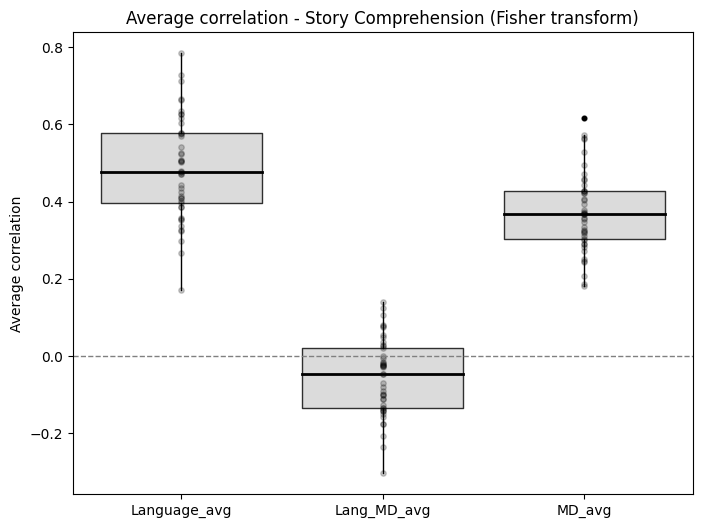

In [423]:
plot_custom_boxplot(boxplot_components, ["Language_avg", "Lang_MD_avg", "MD_avg"])

In [424]:
# Convert region_averages to a DataFrame
results_df = pd.DataFrame.from_dict(region_averages, orient='index').reset_index()
results_df.columns = ['Language', 'Integration_Language', 'Integration_MD', 'Dissociation']

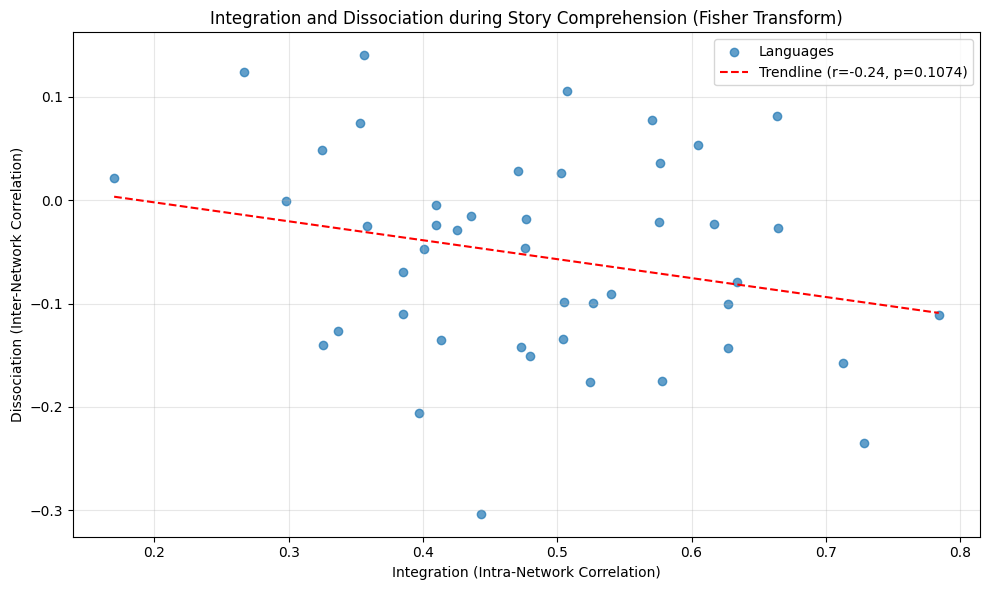

In [425]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(
    results_df['Integration_Language'], 
    results_df['Dissociation'], 
    alpha=0.7, 
    label='Languages'
)

# Trendline
slope, intercept, r_value, p_value, std_err = linregress(results_df['Integration_Language'], results_df['Dissociation'])
x_vals = np.linspace(results_df['Integration_Language'].min(), results_df['Integration_Language'].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red', linestyle='--', label=f'Trendline (r={r_value:.2f}, p={p_value:.4f})')

# Plot settings
if (fisher == True):
    if (paradigm == "story"):
        plt.title("Integration and Dissociation during Story Comprehension (Fisher Transform)")
    else:
        plt.title("Integration and Dissociation during Rest (Fisher Transform)")
elif (paradigm == "story"):
        plt.title("Integration and Dissociation during Story Comprehension (No Fisher Transform)")
else:
        plt.title("Integration and Dissociation during Rest (No Fisher Transform)")

plt.xlabel("Integration (Intra-Network Correlation)")
plt.ylabel("Dissociation (Inter-Network Correlation)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [426]:
# Print statistical analysis
print(f"Pearson's r: {r_value:.2f}, p-value: {p_value:.4f}")

Pearson's r: -0.24, p-value: 0.1074
